In [1]:
# my notes https://docs.google.com/document/d/1YwC5URk4_qqMq1PMHV12hBXpbnKMR5h48wzmpHIZgss/edit
# https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn import metrics

%matplotlib inline

### Helpers

In [3]:
def get_text_columns(d):
    current_filter = d.dtypes == object
    columns = [c for c in current_filter.index if current_filter[c]]
    
    return columns

def confusion_matrix(y_test, predicted):
    confusion_matrix = metrics.confusion_matrix(y_test, predicted)
    class_name = [0, 1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_name))
    plt.xticks(tick_marks, class_name)
    plt.yticks(tick_marks, class_name)

    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap='Blues_r', fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Current Label')
    plt.xlabel('Predicted Label')

def test_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    y_predicted = model.predict(X_test)
    
    confusion_matrix(y_test, y_predicted)
    
    return (model, score, y_predicted)

### Datasets and informations

In [4]:
train = pd.read_csv('./aug_train.csv')
test = pd.read_csv('./aug_test.csv')

In [17]:
# train info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
# length
train.shape

(19158, 14)

### Features

- **enrollee_id:** Unique ID for candidate
- **city:** City code
- **city_ development _index:** Developement index of the city (scaled)
- **gender:** Gender of candidate
- **relevent_experience:** Relevant experience of candidate
- **enrolled_university:** Type of University course enrolled if any
- **education_level:** Education level of candidate
- **major_discipline:** Education major discipline of candidate
- **experience:** Candidate total experience in years
- **company_size:** No of employees in current employer's company
- **company_type:** Type of current employer
- **lastnewjob:** Difference in years between previous job and current job
- **training_hours:** training hours completed
- **target:** 0 – Not looking for job change, 1 – Looking for a job change

In [7]:
test.head(2)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98


### Categorical column coding

In [8]:
cat_cols = get_text_columns(train)
cat_cols

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [9]:

encoder = ce.BinaryEncoder(cols=cat_cols)
train_binenc = encoder.fit_transform(train)

In [10]:
train_binenc.head()

,enrollee_id,city_0,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_development_index,...,company_type_0,company_type_1,company_type_2,company_type_3,last_new_job_0,last_new_job_1,last_new_job_2,last_new_job_3,training_hours,target
0,8949,0,0,0,0,0,0,0,1,0.920,...,0,0,0,1,0,0,0,1,36,1.0
1,29725,0,0,0,0,0,0,1,0,0.776,...,0,0,1,0,0,0,1,0,47,0.0
2,11561,0,0,0,0,0,0,1,1,0.624,...,0,0,0,1,0,0,1,1,83,0.0
3,33241,0,0,0,0,0,1,0,0,0.789,...,0,0,1,0,0,0,1,1,52,1.0
4,666,0,0,0,0,0,1,0,1,0.767,...,0,0,1,1,0,1,0,0,8,0.0


### Train and selected model

In [11]:
# test - 1
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble

In [12]:
y = train_binenc['target']
X = train_binenc.drop(['target', 'enrollee_id'], axis=1)

### Model DecisionTreeClassifier

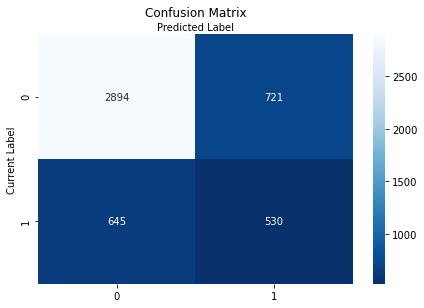

In [13]:
(model1, score1, y_predicted1) = test_model(tree.DecisionTreeClassifier(), X, y)

In [14]:
score1

0.7148225469728601

# Model

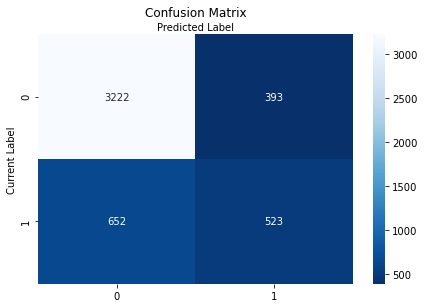

In [23]:
(model2, score2, y_predicted2) = test_model(ensemble.RandomForestClassifier(), X, y)

In [24]:
score2

0.7818371607515657